In [33]:
import numpy as np
import argparse
import locale
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import pairwise_distances
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

data.csv is a table, where each column is a player.  Additionally, there are the following columns:<br>
<br><b>Guest Players</b>: We often have non-ultimate players join us for a night or two.  This marks if any guest players are on a team.
<br><b>ScoreDiff</b>: This is the difference between the given team's score and the opponent's score.  Positive values note a win, and negative values note a loss.
<br><b>TotalPoints</b>: This is the total points played.  For tournaments this is 13.
<br><b>IsOutdoors</b>: This is if the game was played indoors or outdoors.  I notice a different skillset required for indoor games.



In [46]:
data = pd.read_csv('data.csv')
data.head()
data = data.fillna(0)
df = data

The next figure shows the <b>Correlation of Features</b>.  In general, this shows direct and indirect correlations between players.  A positive/negative value between players indicates that thoses players generally play/do not play on the same teams.  There are additional correlations that show between players and the metadata values, but these should not be considered cause/effect relationships

<AxesSubplot:title={'center':'Correlation of Features'}>

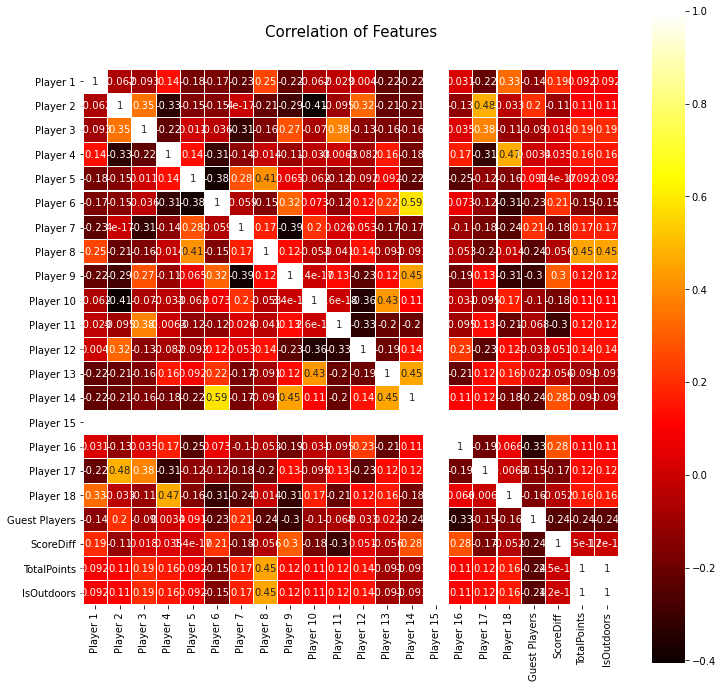

In [47]:
colormap = plt.cm.hot
plt.figure(figsize=(12,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(
    df.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0, 
    square=True, 
    cmap=colormap, 
    linecolor='white', 
    annot=True)

The next couple of cells create ML models and test them for best performance.  I started off with this to determine which model I would use, and am now generally picking between the Gradient Boost and MLP.  It is set to the MLP Regressor below.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["ScoreDiff"]), df["ScoreDiff"], test_size=0.15, random_state=3)


In [58]:
models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LinearRegression()))
#models.append(('LR2', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('GB', GradientBoostingClassifier()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(14), activation='relu', solver='adam', max_iter=5000)))

In [59]:


names = []
scores = []
std = []
for name, model in models:
    model.fit(df.drop(columns=["ScoreDiff"]), df["ScoreDiff"])
    #model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(abs(np.mean(y_test - y_pred)))
    std.append(np.std(y_test - y_pred))
    names.append(name)
    print(scores)
    print(y_pred)


[1.75]
[ 2 -2  1  1  2 -5  1 -3]
[1.75, 0.31227940785577274]
[-0.8807121  -0.41599089  0.2783189   1.60333452  2.5546387   1.32326877
  0.45661395  3.58229289]
[1.75, 0.31227940785577274, 1.0]
[-2 -2  1  2 -2  3 -1  4]
[1.75, 0.31227940785577274, 1.0, 0.5]
[-1 -2  1  2 -2  3  2  4]
[1.75, 0.31227940785577274, 1.0, 0.5, 0.25]
[-1  3  1  2 -2  3 -1  4]
[1.75, 0.31227940785577274, 1.0, 0.5, 0.25, 0.400517229955892]
[-1.448367    0.44219346  0.9556862   1.98026469 -0.68688687  2.09839858
  0.37162624  4.08294687]


In [60]:
modelScores = pd.DataFrame({'Name': names, 'Score': scores, 'STD': std})
(modelScores)

,Name,Score,STD
0,KNN,1.750000,4.293891
1,LR,0.312279,2.206029
2,DT,1.000000,1.802776
3,RF,0.500000,1.732051
4,GB,0.250000,1.089725
5,MLP,0.400517,1.159814


In [61]:
bestModel = modelScores[modelScores["Score"]==min(scores)]
bestModel = models[bestModel.index[0]][1]
bestModel = models[5][1]
bestModel

MLPRegressor(hidden_layer_sizes=14, max_iter=5000)

Below is a curve that shows the MLP model's loss over iterations.  It should flatten towards one.

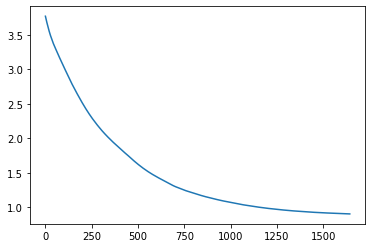

In [62]:
plt.plot(bestModel.loss_curve_)

## Create Combinations

In order to predict the best lines, we need to create a combination of all teams.  We can do this by creating a "populate" table from our initial dataframe, dropping the "ScoreDiff" value, and then appending all combinations.  I use an outside website to generate all combinations, and then map it to our populate dataframe.

### Website: <a href="https://planetcalc.com/3757/">https://planetcalc.com/3757/</a>

In [41]:
populate = df
columnNames = populate.columns
populate.drop(populate.index, inplace=True)
populate = populate.drop(columns=["ScoreDiff"])
populate

In [ ]:
combos = pd.read_csv("Combinations.csv")
combos = combos["combination"]
combos = combos.str.split()
combos = combos.apply(pd.Series)
#combos

In [ ]:
for index, row in combos.iterrows():
    newRow = {}
    for column in row:
        newRow[column] = 1
    populate = populate.append(newRow, ignore_index=True)

In [ ]:
populate["Guest Players"] = 0
populate.to_csv("combosFormatted.csv")

## If you have already created the combinations file, start here.

In [66]:
populate = pd.read_csv("combosFormatted.csv", index_col=0)
populate = populate.fillna(0)
populate

,Player 1,Player 2,Player 3,Player 4,Player 5,Player 6,Player 7,Player 8,Player 9,Player 10,...,Player 12,Player 13,Player 14,Player 15,Player 16,Player 17,Player 18,Guest Players,TotalPoints,IsOutdoors
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14,1
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14,1
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14,1
3,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14,1
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0,14,1
31820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,14,1
31821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,14,1
31822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0,14,1


In [67]:
populate["ScoreDiff"] = bestModel.predict(populate)
populate = populate.drop(columns=["IsOutdoors", "TotalPoints", "Guest Players"])

The next cell removes any players you don't want considered in your line creation.  I removed some players we have limited data on, or that are not going to a given tournament.

In [68]:
remove = ["Player 13", "Player 14", "Player 15"]

for i in remove:
    populate = populate[populate[i]==0]
populate = populate.drop(columns=remove)

,Player 1,Player 2,Player 3,Player 4,Player 5,Player 6,Player 7,Player 8,Player 9,Player 10,Player 11,Player 12,Player 16,Player 17,Player 18,ScoreDiff
913,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,15.825607
657,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,15.669200
6127,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,15.603259
659,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15.130797
703,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,14.823983


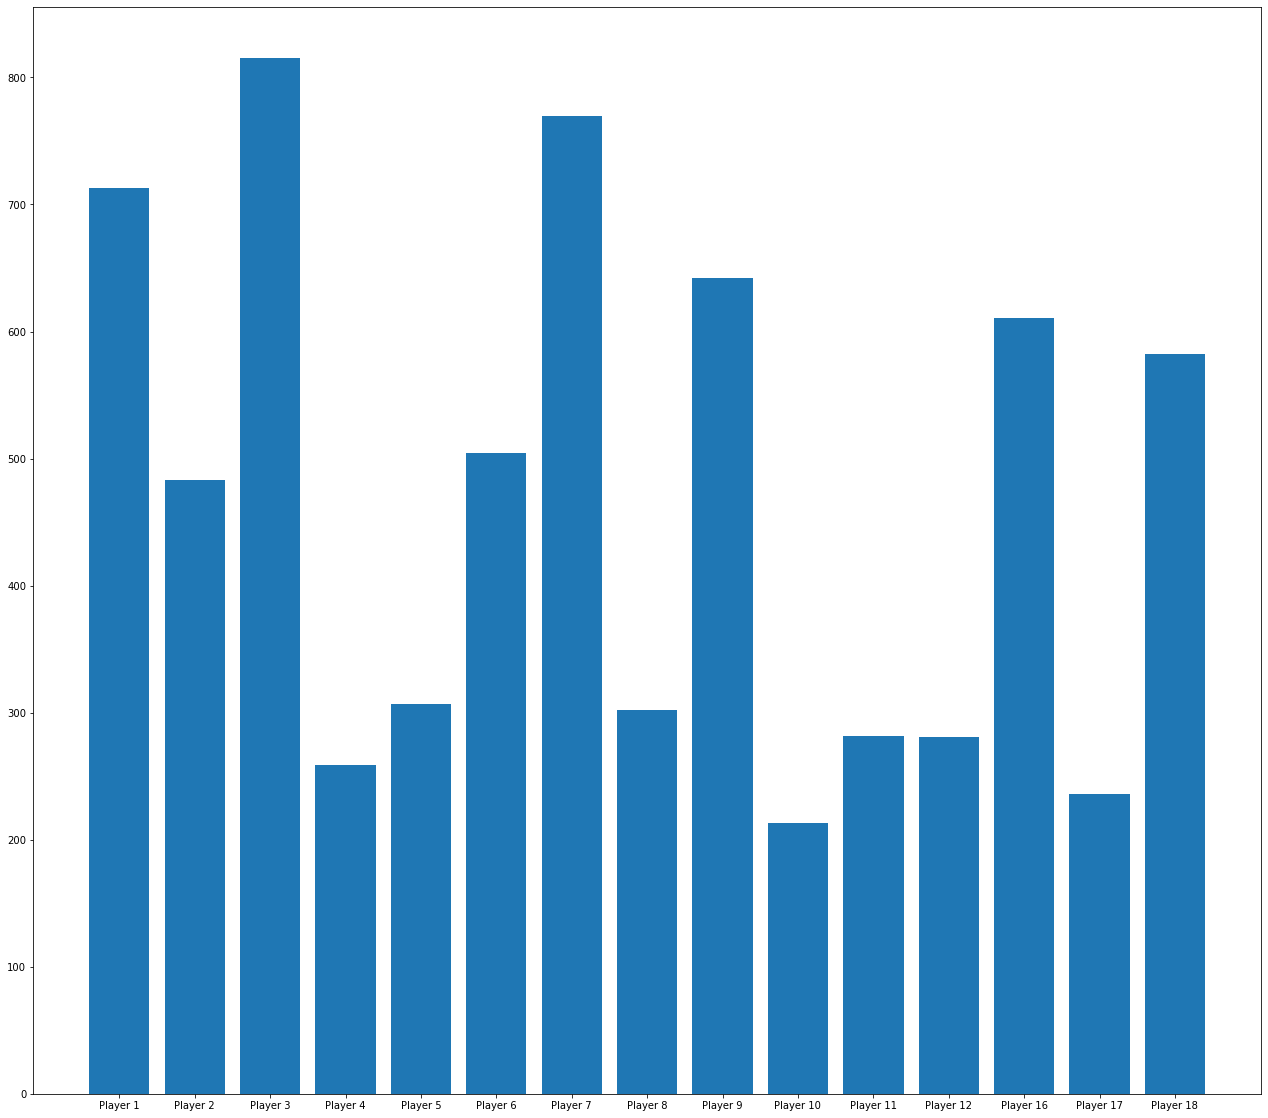

In [69]:
populate.columns
populate = populate.sort_values("ScoreDiff", ascending=False)
plt.figure(figsize=(22, 20))
#plt.bar(populate.columns.drop("ScoreDiff"), populate[populate["ScoreDiff"]==populate["ScoreDiff"].max()].sum().drop("ScoreDiff"))
#topline = populate[populate["ScoreDiff"]>=populate["ScoreDiff"].max()]
#plt.bar(populate[populate["BaileyL"]==1].head(1000).columns.drop("ScoreDiff"), populate[populate["BaileyL"]==1].head(1000).sum().drop("ScoreDiff"))
plt.bar(populate.head(1000).columns.drop("ScoreDiff"), populate.head(1000).sum().drop("ScoreDiff"))
#plt.bar(round(populate["ScoreDiff"]), populate["KallieS"])
#populate.count()
populate.head(5)

## Breakdown of Graph/Table

The table shows the top five lines based on the difference between the two scores.  The graph shows the top 1000 teams generated, and the frequency of each player on the teams. 